In [27]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import torch

%load_ext autoreload
%autoreload 2

from IPython.display import clear_output 
clear_output(wait = True)
import sys 
sys.path.append('..')
from models import LocationScaleFlow, SoftmaxWeight, DIFDensityEstimator,EMDensityEstimator, GeneralizedMultivariateNormalReference
from utils.color_visual import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(256, 197, 3)


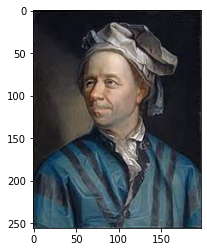

In [28]:
rgb = image.imread("euler.jpg")
plt.imshow(rgb)
print(rgb.shape)

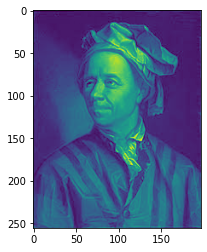

In [29]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))
plt.imshow(grey)

<ipython-input-36-c561633cd754>:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + torch.rand([num_samples,2])


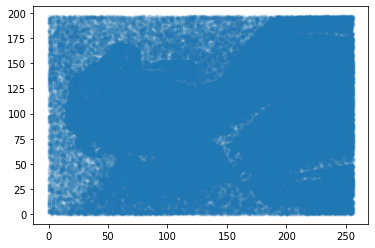

In [36]:
vector_density = grey.flatten()
vector_density = vector_density/torch.sum(vector_density)
lignes, colonnes = grey.shape
num_samples = 200000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + torch.rand([num_samples,2])
'''target_samples[:,1] = target_samples[:,1]/torch.max(target_samples[:,1])
target_samples[:,0] = target_samples[:,0]/torch.max(target_samples[:,0])'''
plt.scatter(target_samples[:,0], target_samples[:, 1], alpha = .1, marker = '.')

<AxesSubplot:xlabel='x', ylabel='y'>

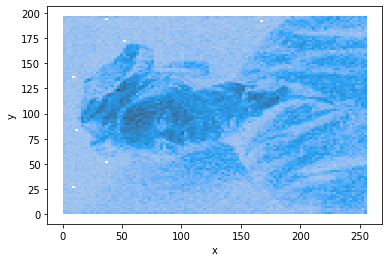

In [37]:
import seaborn as sns 
import pandas as pd
data_x = pd.DataFrame(target_samples[:,0])
data_x['label'] = 'x'
data_y = pd.DataFrame(target_samples[:,1])
data_y['label'] = 'y'
data = pd.DataFrame()
data['x'] = target_samples[:,0]
data['y'] = target_samples[:,1]
sns.histplot(data, x='x', y='y', bins = (100,100))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.82it/s, loss = 10.676993370056152]
C:\Users\Elouan\PycharmProjects\Discretely-Indexed-Flows\venv\lib\site-packages\seaborn\_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

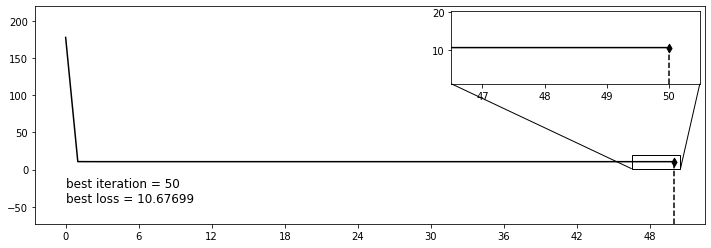

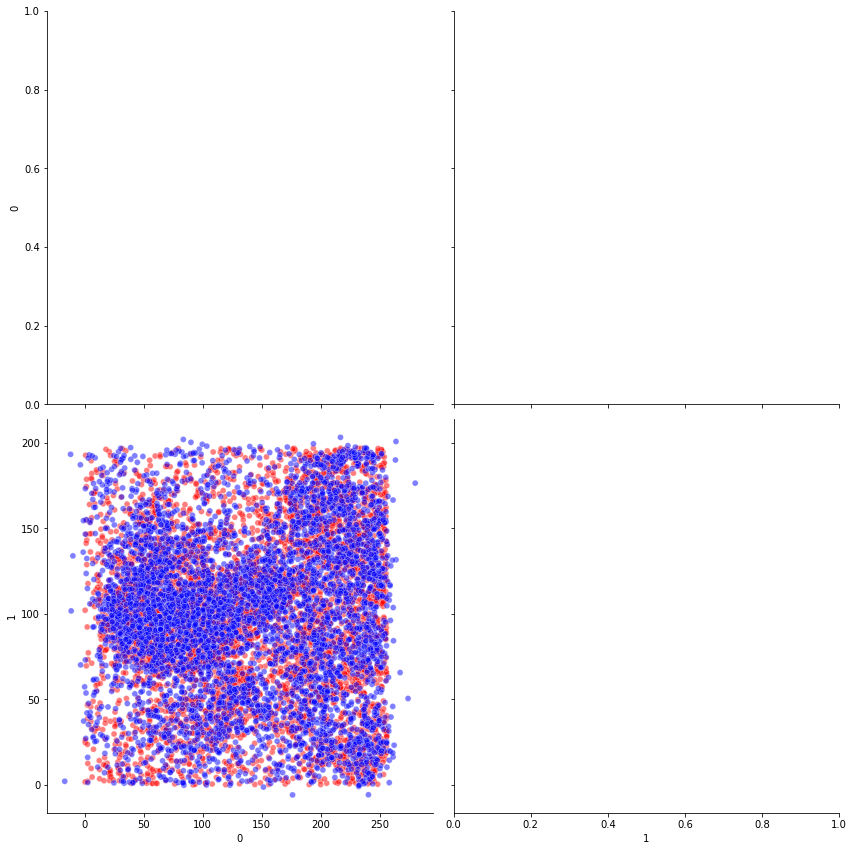

In [38]:
num_samples = target_samples.shape[0]
K = 36
initial_m = torch.cartesian_prod(torch.linspace(0, lignes,6),torch.linspace(0, colonnes, 6))
initial_L = torch.eye(2).unsqueeze(0).repeat(K, 1, 1)
initial_T = LocationScaleFlow(K, 2, initial_m = initial_m,initial_log_s= initial_L, mode = 'full_rank')
EM = EMDensityEstimator(target_samples,K, initial_T = initial_T)
epochs = 50
loss_values = EM.train(epochs,visual=True)
EM.model_visual()

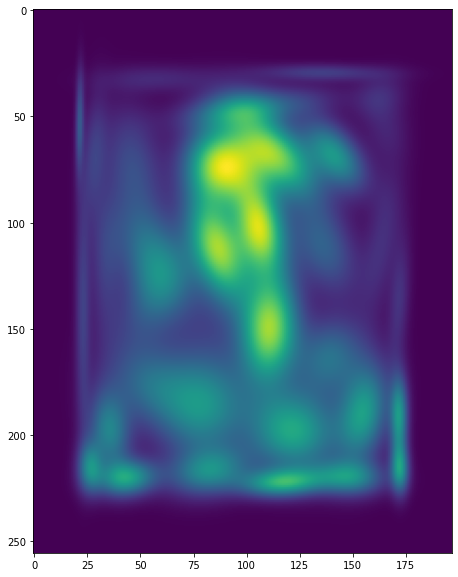

In [33]:
grid = torch.cartesian_prod(torch.linspace(-lignes/8, 1.125*lignes,lignes),torch.linspace(-colonnes/8, 1.125*colonnes, colonnes))
density = torch.exp(EM.log_density(grid)).reshape(lignes,colonnes).T.cpu().detach()
fig = plt.figure(figsize =(10,10))
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]))

In [35]:
from torch import nn
num_samples = target_samples.shape[0]
epochs = 100
batch_size = 50000
initial_T = EM.T
initial_w = SoftmaxWeight(K, 2, [128,128,128], mode = 'NN')
initial_w.f[-1].weight = nn.Parameter(torch.zeros(K, 128))
initial_w.f[-1].bias = nn.Parameter(EM.log_pi)
initial_reference = GeneralizedMultivariateNormalReference(2, initial_log_r = torch.log(2.*torch.ones(2)))
dif = DIFDensityEstimator(target_samples,K, initial_T= initial_T, initial_w = initial_w, initial_reference = initial_reference)
loss_values = dif.train(epochs,batch_size,visual=True)
dif.model_visual()

RuntimeError: CUDA out of memory. Tried to allocate 880.00 MiB (GPU 0; 6.00 GiB total capacity; 3.58 GiB already allocated; 478.44 MiB free; 3.71 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:18<00:00,  3.87it/s, loss = 10.61793327331543]


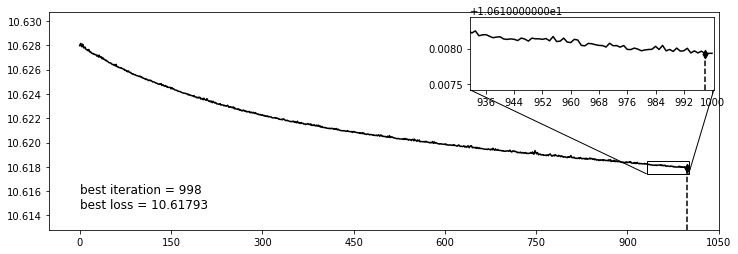

In [25]:
loss_values = dif.train(10*epochs,batch_size,visual=True)

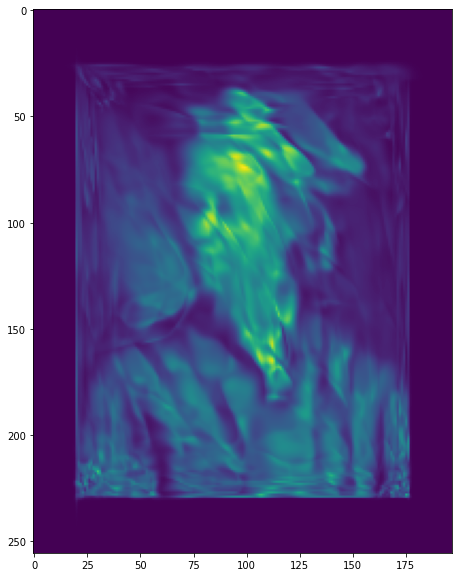

In [26]:
grid = torch.cartesian_prod(torch.linspace(-lignes/8, 1.125*lignes,lignes),torch.linspace(-colonnes/8, 1.125*colonnes, colonnes))
density = torch.exp(dif.log_density(grid)).reshape(lignes,colonnes).T.cpu().detach()
fig = plt.figure(figsize =(10,10))
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]))

In [20]:
print(torch.exp(dif.reference.log_r))

tensor([3.1117, 2.6856], device='cuda:0', grad_fn=<ExpBackward0>)
